In [5]:
# Imports

import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
reg = LinearRegression()
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Section 1. Import and Inspect the Data

### 1.1 Load the dataset and display the first 10 rows.

In [8]:
df = pd.read_csv("insurance.csv")

In [11]:
print(df.head(n=10))

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692


### 1.2 Check for missing values and display summary statistics.

In [12]:
# Missing values in features
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [13]:
# Missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [14]:
# Summary statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Reflection 1: What do you notice about the dataset? Are there any data issues?

There are surprisingly no values missing from the dataset. Also, I am surprised that the max age is 64. 



## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

In [22]:
# Correlations of numeric data
print(df.corr(numeric_only=True))

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


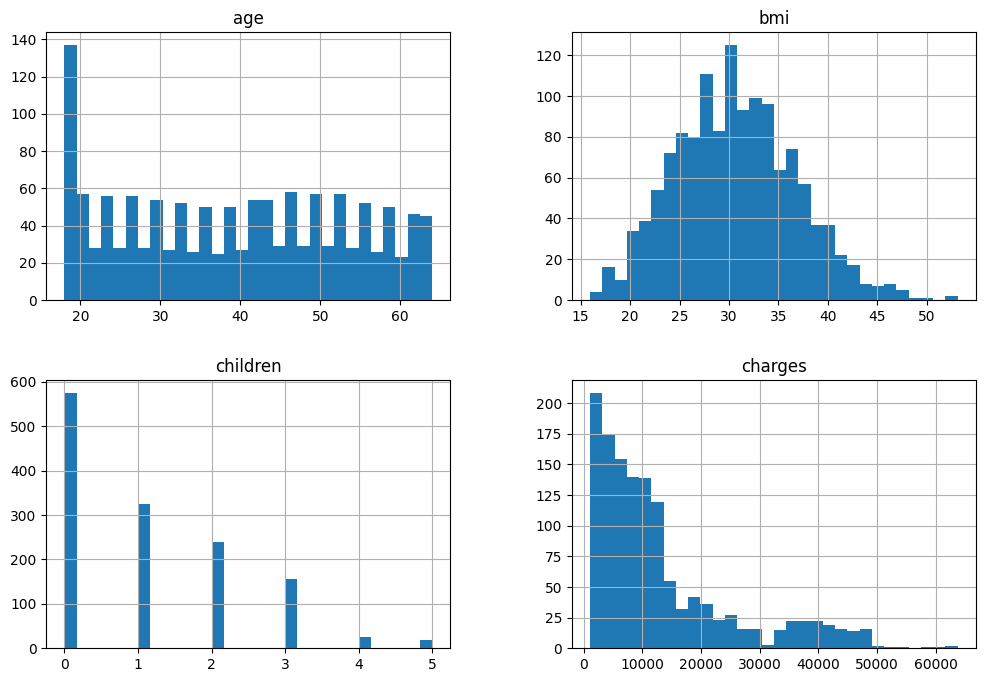

In [15]:
# Histograms
df.hist(bins=30, figsize=(12, 8))
plt.show()

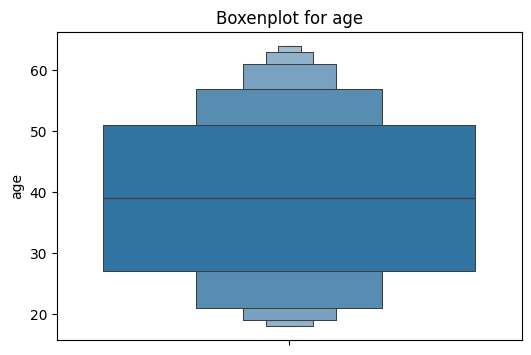

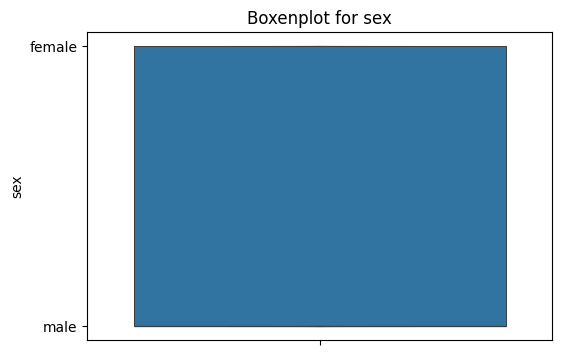

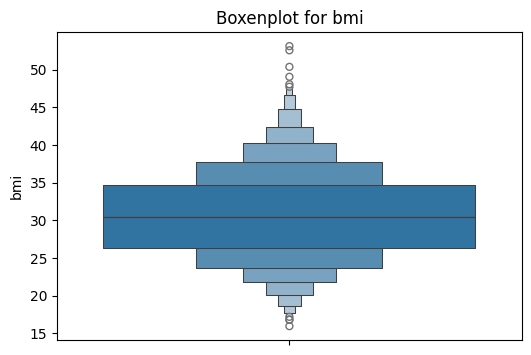

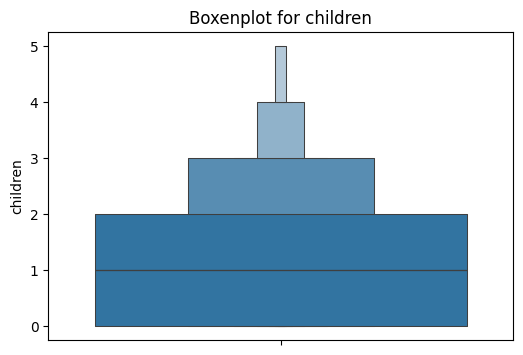

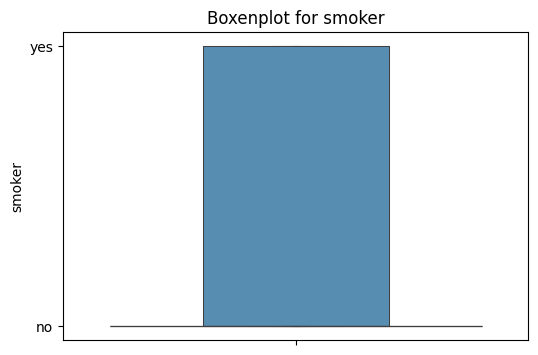

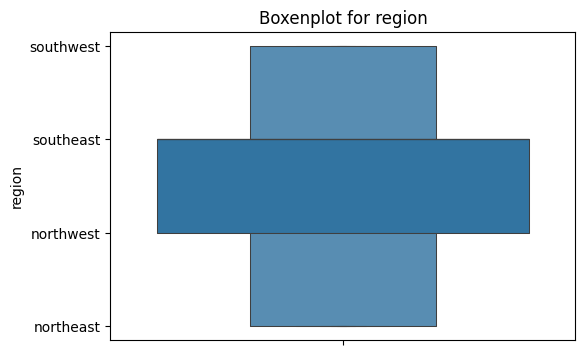

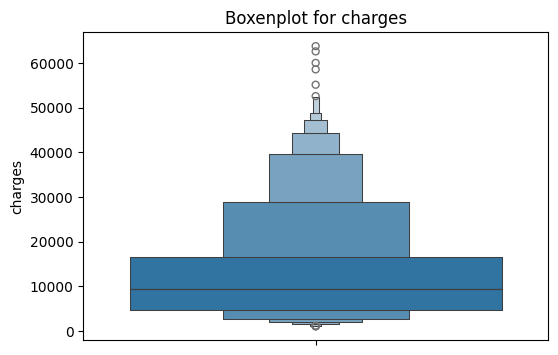

In [24]:
# Boxenplots of the features.
for column in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxenplot(y=df[column])
    plt.title(f'Boxenplot for {column}')
    plt.show()

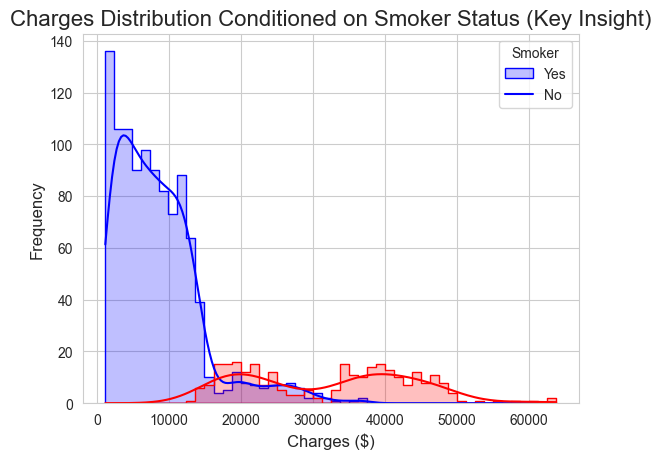

In [28]:
sns.histplot(
    data=df,
    x='charges',
    hue='smoker',
    bins=50,
    kde=True,
    palette={'yes': 'red', 'no': 'blue'},
    element='step' # Use 'step' or 'layer' to overlay the distributions
)
plt.title('Charges Distribution Conditioned on Smoker Status (Key Insight)', fontsize=16)
plt.xlabel('Charges ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Smoker', labels=['Yes', 'No'])
plt.show()

### 2.2 Handle missing values and clean data

There are no missing values.

### 2.3 Feature selection and engineering

Since "Charges" feature is skewed, the log will be taken and used.

In [35]:
# Log of "Charges"

df['log_charges'] = np.log(df['charges'])

<Figure size 1400x1000 with 0 Axes>

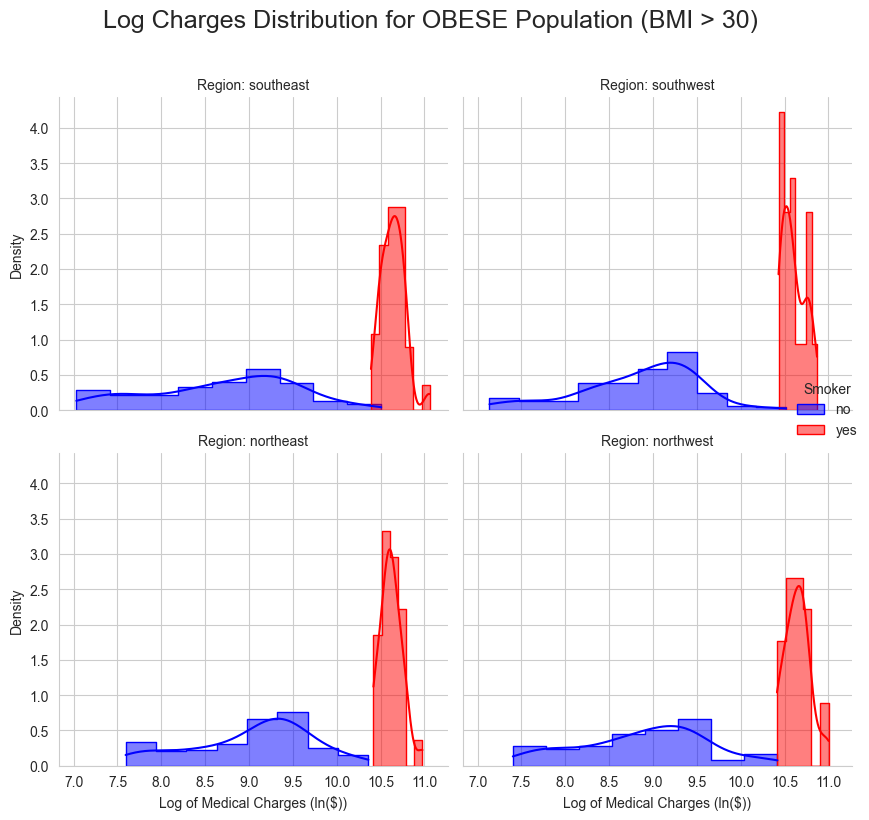

In [34]:
# Distribution of unhealthy characteristics across regions and the related charges

df_obese = df[df['bmi'] > 30].copy()

plt.figure(figsize=(14, 10))

h = sns.FacetGrid(
    df_obese,
    col="region",
    hue="smoker",
    col_wrap=2,
    sharey=True,
    height=4,
    palette={'yes': 'red', 'no': 'blue'}
)

h.map_dataframe(sns.histplot, x="log_charges", kde=True, element='step', stat="density", common_norm=False)
h.add_legend(title="Smoker")
h.set_axis_labels("Log of Medical Charges (ln($))", "Density")
h.set_titles("Region: {col_name}")

plt.suptitle('Log Charges Distribution for OBESE Population (BMI > 30)', y=1.02, fontsize=18)

plt.tight_layout()
plt.show()

### Reflection 2: 

1. What patterns or anomalies do you see? Do any features stand out?  The features that stand out are BMI, Age, and Charges. In Charges and BMI there are outliers. I also think reagion is an interesting feature to explore.

2. What preprocessing steps were necessary to clean and improve the data? Since charges is highly skewed, I will continue the project by using the log of the values.

3. Did you create or modify any features to improve performance? I did not create any new features.

## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

Features are: Age (linear), BMI (linear), Smoking (categorical), Region (categorical)
Target: Charges

### 3.2 Define X and y

In [36]:
X = df[["age","bmi","region","smoker"]]
y = df["charges"]

### Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

I choose the variables that I did because they had the highest positive correlation to charges, so these would be the best place to start. I also am interested to know if region has any influence on charges.

## Section 4. Train a Model (Linear Regression)